## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [11]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## draw_lines has been modified
def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    ysize = img.shape[0]
    xsize = img.shape[1]
   
    slope_left = 0
    cnt_left = 0
    slope_right = 0
    cnt_right = 0
    mark_left = False
    mark_right = False
    for line in lines:
        for x1,y1,x2,y2 in line:
            k = (y2-y1)/(x2-x1)
            if k<0:
                slope_left += k
                cnt_left += 1       
            if k>0:
                slope_right += k
                cnt_right += 1
    if cnt_left == 0:
        cnt_left = 1
    if cnt_right == 0:
        cnt_right = 1
    slope_left = slope_left/cnt_left
    slope_right = slope_right/cnt_right

    for line in lines:
        for x1,y1,x2,y2 in line:
            k = (y2-y1)/(x2-x1)
            if k<0 and (not mark_left):
                cv2.line(img, (x1, y1), (int(x1-(y1-ysize)/slope_left), ysize), color, thickness)
                cv2.line(img, (x1, y1), (int(x1-(y1-int(0.6*ysize))/slope_left), int(0.6*ysize)), color, thickness)
                mark_left = True
            if k>0 and (not mark_right):
                cv2.line(img, (x1, y1), (int(x1-(y1-ysize)/slope_right), ysize), color, thickness)
                cv2.line(img, (x1, y1), (int(x1-(y1-int(0.6*ysize))/slope_right), int(0.6*ysize)), color, thickness)
                mark_right = True                
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Define a filter to show white and yellow colors

def filter(img):
    """
    `img` should be the original image
    
    Returns an image with only white and yellow pixels, other parts are blackened.
    
    """
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define range of white color in HSV
    lower_white = np.array([200,200,200])
    upper_white = np.array([255,255,255])

    # Threshold the HSV image to get only blue colors
    white_mask = cv2.inRange(img, lower_white, upper_white)
    white = cv2.bitwise_and(img, img, mask=white_mask)

    # define range of yellow color in HSV
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([100,255,255])
    
    # Threshold the HSV image to get only blue colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow = cv2.bitwise_and(img, img, mask=yellow_mask)
    
    # Combine    
    return cv2.addWeighted(white, 1., yellow, 1., 0.)
    
    

## Test Images

In [12]:
import os
imagelist = os.listdir("test_images/")
image_names = ["test_images/" + s for s in imagelist]
image_names

['test_images/challenge.jpg',
 'test_images/solidYellowLeft.jpg',
 'test_images/solidWhiteCurve.jpg',
 'test_images/whiteCarLaneSwitch.jpg',
 'test_images/solidWhiteRight.jpg',
 'test_images/solidYellowCurve.jpg',
 'test_images/solidYellowCurve2.jpg']

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


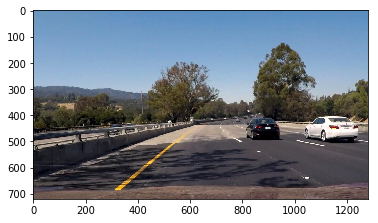

In [13]:
#reading in an image
image = mpimg.imread(image_names[0])

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

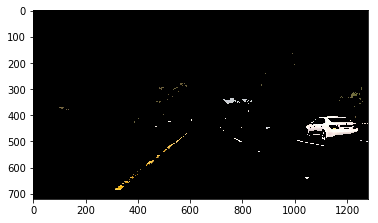

In [14]:
fil = filter(image)
plt.imshow(fil)

## Build a Lane Finding Pipeline

In [15]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def line_annotation(image):
    
    filtered = filter(image)

    # Convert the image to grayscale
    # grayscale(img)
    grayed = grayscale(filtered)

    # Edge detection
    # gaussian_blur(img, kernel_size)
    blurred = gaussian_blur(grayed, 3)
    # canny(img, low_threshold, high_threshold)
    edges = canny(blurred,50,150)

    # Region of Interest
    # region_of_interest(img, vertices)
    ysize = image.shape[0]
    xsize = image.shape[1]

    #left_bottom = [50,539]
    #right_bottom = [950,539]
    #apex = [500,302]

    left_bottom = [int(0.05*xsize),ysize]
    right_bottom = [int(0.95*xsize),ysize]
    apex = [int(0.5*xsize),(0.55*ysize)]

    vertices = [np.array([left_bottom,apex,right_bottom],dtype=np.int32)]
    cropped = region_of_interest(edges, vertices)

    # Hough transform
    # hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_len = 50
    max_line_gap = 100
    lines = hough_lines(cropped, rho, theta, threshold, min_line_len, max_line_gap)
    # Draw the lines on the image
    # weighted_img(img, initial_img, α=0.8, β=1., λ=0.)
    final = weighted_img(lines, image, α=0.5, β=1, λ=0.)

    return final
    #plt.imshow(final)

## Test on Videos

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    result = line_annotation(image)
    
    return result

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 36.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 37.3 s, sys: 100 ms, total: 37.4 s
Wall time: 6.25 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:19<00:00, 34.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 2s, sys: 404 ms, total: 2min 2s
Wall time: 20 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challange

In [22]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:11<00:00, 20.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 4s, sys: 432 ms, total: 1min 4s
Wall time: 11.9 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))